In [1]:
import sys
import os
import warnings
os.environ['OPENBLAS_NUM_THREADS'] = '1'
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import time
import pyarrow.parquet as pq
import pyarrow as pa
import scipy
import implicit
import bisect
import sklearn.metrics as m
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

In [3]:
LOCAL_DATA_PATH = './context_data/'
SPLIT_SEED = 42
DATA_FILE = 'competition_data_final_pqt'
TARGET_FILE = 'public_train.pqt'
SUBMISSION_FILE = 'submit.pqt'

In [4]:
id_to_submit = pq.read_table(f'{LOCAL_DATA_PATH}/{SUBMISSION_FILE}').to_pandas()

In [5]:
# pqf = pq.ParquetFile(f'{LOCAL_DATA_PATH}/{DATA_FILE}')
pqd = pq.ParquetDataset(f'{LOCAL_DATA_PATH}/{DATA_FILE}')
pqd.files

['./context_data//competition_data_final_pqt/part-00000-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00001-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00002-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00003-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00004-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00005-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00006-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00007-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00008-aba60f69-2b63-4cc1-95ca-

In [217]:
data_agg = None
for ifile in pqd.files :

    #data = pq.read_table(f'{LOCAL_DATA_PATH}/{DATA_FILE}/{ifile}')
    data = pq.read_table(f'{ifile}')
    #pd.DataFrame([(z.name, z.type) for z in data.schema], columns = [['field', 'type']])

    data_agg0 = data.select(['user_id', 'url_host', 'request_cnt']).\
        group_by(['user_id', 'url_host']).aggregate([('request_cnt', "sum")])
    
    data_agg1 = data.select(['user_id','date', 'part_of_day', 'request_cnt']).\
        group_by(['user_id', 'date', 'part_of_day']).aggregate([('request_cnt', "sum")])
    
    data_agg2 = data.select(['user_id', 'cpe_model_os_type', 'price']).\
        group_by(['user_id', ]).aggregate([('cpe_model_os_type', "max"), ('price', "max")])
    
    if data_agg is None :
        data_agg  = data_agg0
        data_aggB = data_agg1
        data_aggZ = data_agg2
        print(data.to_pandas().head())
    else :
        data_agg  = pa.concat_tables([data_agg, data_agg0],promote=False)
        data_aggB = pa.concat_tables([data_aggB,data_agg1],promote=False)
        data_aggZ = pa.concat_tables([data_aggZ,data_agg2],promote=False)
    
    del data, data_agg0, data_agg1, data_agg2
    
data_agg  = data_agg.to_pandas()
data_aggB = data_aggB.to_pandas()
data_aggZ = data_aggZ.to_pandas().fillna(0)

          region_name  city_name cpe_manufacturer_name cpe_model_name  \
0  Краснодарский край  Краснодар                 Apple       iPhone 7   
1  Краснодарский край  Краснодар                 Apple       iPhone 7   
2  Краснодарский край  Краснодар                 Apple       iPhone 7   
3  Краснодарский край  Краснодар                 Apple       iPhone 7   
4  Краснодарский край  Краснодар                 Apple       iPhone 7   

                      url_host cpe_type_cd cpe_model_os_type    price  \
0                ad.adriver.ru  smartphone               iOS  20368.0   
1                    apple.com  smartphone               iOS  20368.0   
2       avatars.mds.yandex.net  smartphone               iOS  20368.0   
3  googleads.g.doubleclick.net  smartphone               iOS  20368.0   
4  googleads.g.doubleclick.net  smartphone               iOS  20368.0   

         date part_of_day  request_cnt  user_id  
0  2022-06-15     morning            1    45098  
1  2022-06-19     morn

Регион   
, населенный пункт   
, производиель устройства   
, модель устроства   
, домен, с которого пришел рекламный запрос   
, тип устройства (смартфон или что-то другое)   
, операционка на устройстве   
, оценка цены устройства   
, дата   
, время дня (утро, вечер ...)   
, число запросов   
, id пользователя   

In [218]:
data_agg.head(), data_aggB.head(), data_agg.describe(), data_aggB.describe(), data_aggZ

(   request_cnt_sum  user_id                     url_host
 0               12    45098                ad.adriver.ru
 1              491    45098                    apple.com
 2              174    45098       avatars.mds.yandex.net
 3              305    45098  googleads.g.doubleclick.net
 4              446    45098                  i.ytimg.com,
    request_cnt_sum  user_id        date part_of_day
 0               10    45098  2022-06-15     morning
 1                2    45098  2022-06-19     morning
 2                8    45098  2022-06-12         day
 3               16    45098  2022-05-16         day
 4               13    45098  2022-05-30         day,
        request_cnt_sum       user_id
 count     3.227767e+07  3.227767e+07
 mean      1.724852e+01  2.074424e+05
 std       6.242678e+01  1.200214e+05
 min       1.000000e+00  0.000000e+00
 25%       1.000000e+00  1.037680e+05
 50%       2.000000e+00  2.077030e+05
 75%       8.000000e+00  3.116840e+05
 max       3.938000e+03  4.1

In [224]:
if 0 :
    data_aggC = pd.pivot_table(data_aggB[['user_id','DW','request_cnt_sum']],
                                index='user_id', columns='DW', values='request_cnt_sum', 
                                aggfunc=np.sum, fill_value=0).reset_index()
if 0 :
    data_aggC = data_aggB[['user_id','part_of_day','request_cnt_sum']].groupby(['user_id','part_of_day']).mean()
if 0 :
    data_aggC = pd.pivot_table(data_aggB[['user_id','part_of_day','request_cnt_sum']],
                                index='user_id', columns='part_of_day', values='request_cnt_sum', 
                                aggfunc=np.mean, fill_value=0).reset_index()
if 1 :
    data_aggB['DW'] = pd.to_datetime(data_aggB.date).dt.day_of_week.astype(str)+'.'+data_aggB.part_of_day
    data_aggC = pd.pivot_table(data_aggB[['user_id','DW','request_cnt_sum']],
                                index='user_id', columns='DW', values='request_cnt_sum', 
                                aggfunc=np.mean, fill_value=0).reset_index()
    
    data_aggD = pd.pivot_table(data_aggB[['user_id','part_of_day','request_cnt_sum']],
                                index='user_id', columns='part_of_day', values='request_cnt_sum', 
                                aggfunc=np.mean, fill_value=0).reset_index()
    data_aggC = data_aggC.merge(data_aggD,how='inner',on=['user_id'])
    
    data_aggB['DW'] = 'DW' + pd.to_datetime(data_aggB.date).dt.day_of_week.astype(str)
    data_aggD = pd.pivot_table(data_aggB[['user_id','DW','request_cnt_sum']],
                                index='user_id', columns='DW', values='request_cnt_sum', 
                                aggfunc=np.mean, fill_value=0).reset_index()
    data_aggC = data_aggC.merge(data_aggD,how='inner',on=['user_id'])

    data_aggC = data_aggC.merge(data_aggZ[['user_id','price_max']],how='inner',on=['user_id'])



In [225]:
data_aggC.columns

Index(['user_id', '0.day', '0.evening', '0.morning', '0.night', '1.day',
       '1.evening', '1.morning', '1.night', '2.day', '2.evening', '2.morning',
       '2.night', '3.day', '3.evening', '3.morning', '3.night', '4.day',
       '4.evening', '4.morning', '4.night', '5.day', '5.evening', '5.morning',
       '5.night', '6.day', '6.evening', '6.morning', '6.night', 'day',
       'evening', 'morning', 'night', 'DW0', 'DW1', 'DW2', 'DW3', 'DW4', 'DW5',
       'DW6', 'price_max'],
      dtype='object')

In [226]:
if 0 :
    data_aggC.columns=('user_id','a0','a1','a2','a3','a4','a5','a6')
    data_aggC['A']=data_aggC.a0+data_aggC.a1+data_aggC.a2+data_aggC.a3+data_aggC.a4+data_aggC.a5+data_aggC.a6
    data_aggC['A0']=data_aggC.a0/data_aggC.A
    data_aggC['A1']=data_aggC.a1/data_aggC.A
    data_aggC['A2']=data_aggC.a2/data_aggC.A
    data_aggC['A3']=data_aggC.a3/data_aggC.A
    data_aggC['A4']=data_aggC.a4/data_aggC.A
    data_aggC['A5']=data_aggC.a5/data_aggC.A
    data_aggC['A6']=data_aggC.a6/data_aggC.A
    data_aggC      =data_aggC.drop(['a0','a1','a2','a3','a4','a5','a6','A','A1'], axis=1)
if 1 :
    data_aggC['A']=data_aggC.day+data_aggC.evening+data_aggC.morning+data_aggC.night
    data_aggC['A000']=data_aggC.day/data_aggC.A
    data_aggC['A001']=data_aggC.evening/data_aggC.A
    data_aggC['A002']=data_aggC.morning/data_aggC.A
    data_aggC['A003']=data_aggC.night/data_aggC.A
    #data_aggC = data_aggC.drop(['day','morning','evening'],axis=1)
    
if 1 :
    data_aggC['DWA']=data_aggC.DW0+data_aggC.DW1+data_aggC.DW2+data_aggC.DW3+data_aggC.DW4+data_aggC.DW5+data_aggC.DW6
    data_aggC['DW000']=data_aggC.DW0/data_aggC.DWA
    data_aggC['DW001']=data_aggC.DW1/data_aggC.DWA
    data_aggC['DW002']=data_aggC.DW2/data_aggC.DWA
    data_aggC['DW003']=data_aggC.DW3/data_aggC.DWA
    data_aggC['DW004']=data_aggC.DW4/data_aggC.DWA
    data_aggC['DW005']=data_aggC.DW5/data_aggC.DWA
    data_aggC['DW006']=data_aggC.DW6/data_aggC.DWA
    
    
data_aggC.columns

Index(['user_id', '0.day', '0.evening', '0.morning', '0.night', '1.day',
       '1.evening', '1.morning', '1.night', '2.day', '2.evening', '2.morning',
       '2.night', '3.day', '3.evening', '3.morning', '3.night', '4.day',
       '4.evening', '4.morning', '4.night', '5.day', '5.evening', '5.morning',
       '5.night', '6.day', '6.evening', '6.morning', '6.night', 'day',
       'evening', 'morning', 'night', 'DW0', 'DW1', 'DW2', 'DW3', 'DW4', 'DW5',
       'DW6', 'price_max', 'A', 'A000', 'A001', 'A002', 'A003', 'DWA', 'DW000',
       'DW001', 'DW002', 'DW003', 'DW004', 'DW005', 'DW006'],
      dtype='object')

In [10]:
targets = pq.read_table(f'{LOCAL_DATA_PATH}/{TARGET_FILE}')
pd.DataFrame([(z.name, z.type) for z in targets.schema], columns = [['field', 'type']])

,field,type
0,age,double
1,is_male,string
2,user_id,int64
3,__index_level_0__,int64


In [11]:
targets.to_pandas().describe(), id_to_submit.describe()

(                 age        user_id
 count  269999.000000  270000.000000
 mean       38.789773  207547.794719
 std        11.746168  119901.875310
 min         0.000000       0.000000
 25%        30.000000  103651.500000
 50%        37.000000  207456.500000
 75%        47.000000  311565.250000
 max        91.000000  415313.000000,
              user_id
 count  144724.000000
 mean   207821.412489
 std    119885.755418
 min         6.000000
 25%    104091.500000
 50%    207961.500000
 75%    311353.250000
 max    415316.000000)

In [12]:
url_set = set(data_agg['url_host'])
print(f'{len(url_set)} urls')
url_dict = {url: idurl for url, idurl in zip(url_set, range(len(url_set)))}
usr_set = set(data_agg['user_id'])
print(f'{len(usr_set)} users')
usr_dict = {usr: user_id for usr, user_id in zip(usr_set, range(len(usr_set)))}

199683 urls
415317 users


In [13]:
import faiss

In [197]:
%%time
values = np.array(data_agg['request_cnt_sum'])
rows = np.array(data_agg['user_id'].map(usr_dict))
cols = np.array(data_agg['url_host'].map(url_dict))
mat = scipy.sparse.coo_matrix((values, (rows, cols)), shape=(rows.max() + 1, cols.max() + 1))
als = implicit.approximate_als.FaissAlternatingLeastSquares(factors = 250, iterations = 30, use_gpu = False, \
       calculate_training_loss = False, regularization = 0.1)

CPU times: user 3.65 s, sys: 228 ms, total: 3.87 s
Wall time: 3.86 s


In [198]:
als.model.__dict__

{'item_factors': None,
 'user_factors': None,
 '_user_norms': None,
 '_item_norms': None,
 'num_threads': 0,
 'factors': 250,
 'regularization': 0.1,
 'alpha': 1.0,
 'dtype': dtype('float32'),
 'use_native': True,
 'use_cg': True,
 'iterations': 30,
 'calculate_training_loss': False,
 'fit_callback': None,
 'cg_steps': 3,
 'random_state': None,
 '_YtY': None,
 '_XtX': None}

In [199]:
%%time
als.fit(mat)
u_factors = als.model.user_factors 
d_factors = als.model.item_factors

  0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 52min 37s, sys: 6.69 s, total: 52min 44s
Wall time: 6min 41s


In [200]:
u_factors.shape, d_factors.shape, 270000+144277

((415317, 250), (199683, 250), 414277)

## Получим оценку по полу

In [227]:
%%time
inv_usr_map = {v: k for k, v in usr_dict.items()}
usr_emb = pd.DataFrame(u_factors)
usr_emb['user_id'] = usr_emb.index.map(inv_usr_map)
usr_emb = usr_emb.merge(data_aggC, how = 'inner', on = ['user_id'])
usr_targets = targets.to_pandas()
df = usr_targets.merge(usr_emb,   how = 'inner', on = ['user_id'])
#df = usr_targets.merge(data_aggC, how = 'inner', on = ['user_id'])
df = df[df['is_male'] != 'NA']
df = df.dropna()
df['is_male'] = df['is_male'].map(int)
df['is_male'].value_counts()

CPU times: user 2.97 s, sys: 448 ms, total: 3.42 s
Wall time: 3.42 s


1    135331
0    128994
Name: is_male, dtype: int64

In [228]:
%%time
x_train, x_test, y_train, y_test = train_test_split(\
    df.drop(['user_id', 'age', 'is_male'], axis = 1), df['is_male'], test_size = 0.33, random_state = SPLIT_SEED)
clf = CatBoostClassifier()
clf.fit(x_train, y_train, verbose = False)
print(f'GINI по полу {2 * m.roc_auc_score(y_test, clf.predict_proba(x_test)[:,1]) - 1:2.3f}')

GINI по полу 0.675
CPU times: user 9min 16s, sys: 12.6 s, total: 9min 29s
Wall time: 1min 13s


In [229]:
clf.fit(df.drop(['user_id', 'age', 'is_male'], axis = 1), df['is_male'], verbose = False)
id_to_submit['is_male'] = clf.predict_proba(id_to_submit.merge(usr_emb, how = 'inner', on = ['user_id']))[:,1]

## Получим оценку по возрасту

In [230]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

%matplotlib inline
sns.set_style('darkgrid')

In [231]:
def age_bucket(x):
    return bisect.bisect_left([18,25,35,45,55,65], x)

<AxesSubplot:xlabel='age', ylabel='Count'>

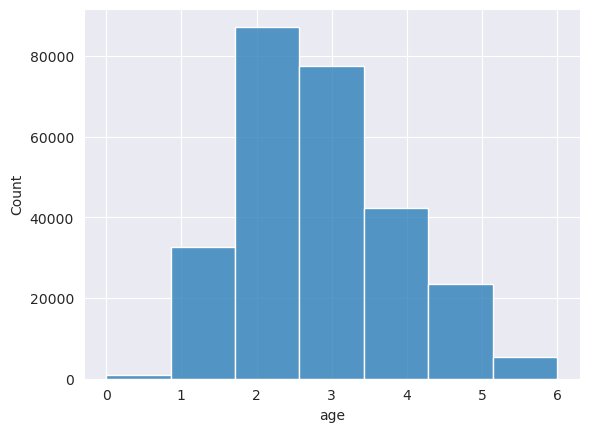

In [232]:
df = usr_targets.merge(usr_emb, how = 'inner', on = ['user_id'])
df = df[df['age'] != 'NA']
df = df.dropna()
df['age'] = df['age'].map(age_bucket)
sns.histplot(df['age'], bins = 7)

In [233]:
x_train, x_test, y_train, y_test = train_test_split(\
    df.drop(['user_id', 'age', 'is_male'], axis = 1), df['age'], test_size = 0.33, random_state = SPLIT_SEED)

clf = CatBoostClassifier()
clf.fit(x_train, y_train, verbose = False)
print(m.classification_report(y_test, clf.predict(x_test), \
                            target_names = ['<18', '18-25','25-34', '35-44', '45-54', '55-65', '65+']))

              precision    recall  f1-score   support

         <18       0.00      0.00      0.00       349
       18-25       0.52      0.32      0.40     10663
       25-34       0.48      0.62      0.54     28815
       35-44       0.40      0.51      0.45     25791
       45-54       0.37      0.21      0.27     13931
       55-65       0.42      0.21      0.28      7688
         65+       0.48      0.02      0.03      1849

    accuracy                           0.44     89086
   macro avg       0.38      0.27      0.28     89086
weighted avg       0.44      0.44      0.42     89086



In [234]:
clf.fit(df.drop(['user_id', 'age', 'is_male'], axis = 1), df['age'], verbose = False)
id_to_submit['age'] = clf.predict(id_to_submit[['user_id']].merge(usr_emb, how = 'inner', on = ['user_id']))

## Сабмит

In [235]:
id_to_submit.head()

,user_id,is_male,age
221301,221301,0.962885,1
31271,31271,0.486043,3
211594,211594,0.491795,2
253119,253119,0.461598,3
192578,192578,0.799842,2


In [236]:
id_to_submit.to_csv(f'{LOCAL_DATA_PATH}/submission5.csv', index = False)

In [237]:
! head $LOCAL_DATA_PATH/submission1.csv

user_id,is_male,age
221301,0.9523721503994212,2
31271,0.540058202285835,3
211594,0.4921148361193288,2
253119,0.5031936669434278,2
192578,0.7343094598406392,2
268458,0.28223318330597313,2
205507,0.5256998725263032,3
341343,0.6329608219845485,3
282144,0.026135216529779966,2


# Скор на лидерборде

In [187]:
#context_scorer(submission, answers)